In [ ]:
#Importo il modulo drive, fornito da Colab, per interagire con Google Drive.
from google.colab import drive
#Monta il mio Google Drive nella directory locale /content/drive del runtime, con la garanzia che sia in uno stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 128,    #Numero di campioni elaborati in un singolo batch.
    "n_workers": 2,       #Processi del DataLoader che pre-caricano i dati in parallelo.
    "max_seq_len": 1024,  #Lunghezza massima (token): i testi più lunghi verranno troncati.
                          #Quelli più corti verranno riempiti con il token <pad>.

    # PARAMETRI DEL MODELLO:
    "embedding_dim": 128,   #Dimensione dei vettori di embedding (spazio semantico dei token).
    "hidden_dim": 128,      #Neuroni del layer nascosto dell’MLP.
    "output_dim": 2,        #Dimensione dell’output: 2 classi --> 0 = Human , 1 = GenAI.

     # PARAMETRI DI TRAINING:
    "learning_rate": 8e-4,    #Tasso di apprendimento dell’ottimizzatore (es. Adam).
    "epochs": 12,             #Numero di epoche: quante volte l’intero dataset viene visto dal modello.

    # PARAMETRI DI VALIDAZIONE/REGOLARIZZAZIONE:
    "val_size": 0.2,            #Frazione di split per validazione (hold-out del 20%).
    "dropout": 0.2,             #Probabilità di spegnimento neuroni a train-time (keep probability q=0.8).
    "weight_decay": 2e-4,       #Penalità L2 per controllare l'overfitting.
    "label_smoothing": 0.02,    #Smoothing del target (per K=2: [0.98, 0.02] sul vettore obiettivo).
    "patience": 4               #Early stopping se la val-loss non migliora per 4 epoche consecutive.
}

In [ ]:
# STANDARD LIBRARY (Python):
import os                        #Gestione percorsi, variabili d'ambiente, I/O di base.
import math                      #Funzioni matematiche (p.es. ceil, log, sqrt).
import copy                      #Copie profonde/superficiali di oggetti complessi (es. pesi modello).
import re                        #Espressioni regolari per pulizia e parsing dei testi.
import random                    #RNG standard (per seed e sampling semplice).
from collections import Counter  #Conteggi frequenze di token/etichette.

# CALCOLO NUMERICO / DATI TABELLARI:
import numpy as np               #Tensori/array N-dim, operazioni numeriche vettorizzate.
import pandas as pd              #Tabelle, CSV/Parquet, join/filter/groupby.

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici 2D (linee, barre, scatter, heatmap via imshow).
import seaborn as sns            #Wrapper statistico su Matplotlib (stile + funzioni comode).

# PROGRESS BAR (notebook-friendly):
from tqdm.notebook import tqdm   #Barra di avanzamento per loop su batch/epoche.

# PyTorch (core + dataset + mixed precision):
import torch                                              #Tensori e operazioni su CPU/GPU; gestione device.
import torch.nn as nn                                     #Moduli di rete (Linear, Dropout, ReLU, etc).
import torch.nn.functional as F                           #Funzioni funzionali (relu, cross_entropy, log_softmax, etc).
from torch.utils.data import Dataset, DataLoader, Subset  #API per dataset custom e mini-batch.
from torch.cuda import amp                                #Per AMP.
from torch.cuda.amp import autocast, GradScaler           #AMP: mixed precision e scaler.

# Scikit-learn (split + metriche):
from sklearn.model_selection import train_test_split      #Split train/val/test stratificato.
from sklearn.metrics import (
    accuracy_score,                                       #Accuratezza: (TP+TN)/totale;
    balanced_accuracy_score,                              #Media delle recall per classe;
    f1_score,                                             #F1 = 2·(precision·recall)/(precision+recall);
    precision_recall_fscore_support,                      #Precision, recall, fscore per classe e macro/micro;
    confusion_matrix,                                     #Matrice di confusione (TP/TN/FP/FN per classe);
    classification_report                                 #Report testuale riassuntivo per classe e aggregati.
)

In [ ]:
# --- DEVICE & A100 SETUP -----------------------------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    name = torch.cuda.get_device_name(0)
    cap  = torch.cuda.get_device_capability(0)  # (major, minor) → A100 = (8,0)
    print(f"[LOG] Device → cuda:0 | GPU: {name} | CC: {cap} | CUDA: {torch.version.cuda} | Torch: {torch.__version__}")

    # Sblocca TensorFloat-32 su Ampere+ (A100): velocizza matmul/conv mantenendo precisione FP32 accettabile
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    # Suggerisci a PyTorch di usare kernel a precisione più alta per i matmul FP32
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

    # Su Ampere (CC >= 8) usiamo AMP in **bfloat16** (niente GradScaler necessario)
    USE_BF16 = cap[0] >= 8
    AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16
else:
    print(f"[LOG] Device → cpu | Torch: {torch.__version__}")
    USE_BF16  = False
    AMP_DTYPE = torch.float32  # irrilevante su CPU

[LOG] Device → cuda:0 | GPU: NVIDIA A100-SXM4-40GB | CC: (8, 0) | CUDA: 12.6 | Torch: 2.8.0+cu126


In [ ]:
def collate_trim(batch):
    """
    Collate function per DataLoader.
    Input: batch = lista di tuple (x, y), con x tensore 1D di token ID (padded con 0) e y etichetta.
    Output: (xs_trim, ys) con xs_trim di shape [B, L_batch] dove L_batch = max lunghezza reale nel batch.
    Assunzione: PAD == 0 e non viene usato come token "valido".
    """
    xs, ys = zip(*batch)  #Unpack: xs = sequenze, ys = etichette; xs è una tupla di tensori 1D [T_max].

    #Lunghezza reale per sequenza: conta i token != 0 (cioè non PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    #Evita edge case L_batch = 0 se tutte le sequenze sono vuote; garantisce almeno 1.
    maxlen = max(1, max(lens)) if lens else 1

    #Taglia ogni sequenza alla lunghezza massima del batch: riduce compute/memoria.
    xs_trim = torch.stack([x[:maxlen] for x in xs])  # Shape [B, maxlen]

    #Stack delle etichette in un tensore 1D di shape [B]
    ys = torch.stack(ys)

    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader "veloce":
      - usa collate_trim per dynamic padding/trimming per-batch;
      - pin_memory su CUDA per velocizzare i transfer CPU→GPU (.to(device, non_blocking=True));
      - se n_workers > 0: worker persistenti + prefetch di più batch.
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True   #Evita teardown/respawn dei worker ad ogni epoca.
        kwargs["prefetch_factor"] = 4         #Ogni worker pre-carica N batch (default=2); 4 = più aggressivo.

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),   #Consigliato su CUDA; innocuo su CPU.
        collate_fn=collate_trim,              #Applica il trimming dinamico definito sopra.
        **kwargs
    )

In [ ]:
# --- HOLDOUT per VALIDATION + TEST fisso (EN → IT test) -------------------------------
SEED = 42
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"   # attenzione: TESI-Classificazione
os.makedirs(BASE, exist_ok=True)

TRAIN_CSV_ORIG = f"{BASE}/en_train_full.csv"
DEV_CSV_ORIG   = f"{BASE}/en_dev_full.csv"

VAL_CSV        = f"{BASE}/en_val_holdout.csv"      # VALIDATION = parte del DEV
TEST_CSV       = f"{BASE}/it_dev_full.csv"         # TEST fisso (italiano, ~1843 righe)

# Carica i dataset
df_train = pd.read_csv(TRAIN_CSV_ORIG)
df_dev   = pd.read_csv(DEV_CSV_ORIG)
assert "label" in df_train.columns and "label" in df_dev.columns, "Manca 'label' nei CSV."

# Usa tutto il DEV come validation
df_val = df_dev.copy()

# Reset index e salva
df_val = df_val.reset_index(drop=True)
df_val.to_csv(VAL_CSV, index=False)

print(f"[LOG] TRAIN: {len(df_train)} | DEV: {len(df_dev)} | VAL: {len(df_val)} | TEST fisso: {len(pd.read_csv(TEST_CSV))}")
print("[LOG] VAL label:",  df_val["label"].value_counts().sort_index().to_dict())
print("[LOG] TEST label:", pd.read_csv(TEST_CSV)["label"].value_counts().sort_index().to_dict())

[LOG] TRAIN: 610676 | DEV: 261849 | VAL: 261849 | TEST fisso: 1843
[LOG] VAL label: {0: 98041, 1: 163808}
[LOG] TEST label: {1: 1843}


In [ ]:
# ---- Subsample 1/4 di TRAIN e di VALIDATION (stratificato) ------------------
FRAC_USE = 0.25

def sample_frac_stratified(df, frac=0.25, seed=42):
    if "label" in df.columns and df["label"].nunique() >= 2:
        parts = [g.sample(n=max(1,int(round(len(g)*frac))), random_state=seed, replace=False)
                 for _, g in df.groupby("label", sort=False)]
        out = pd.concat(parts, ignore_index=False)
    else:
        out = df.sample(n=max(1,int(round(len(df)*frac))), random_state=seed, replace=False)
    return out.sample(frac=1.0, random_state=seed).reset_index(drop=True)

df_train_sub = sample_frac_stratified(df_train, frac=FRAC_USE, seed=SEED)
df_val_sub   = sample_frac_stratified(df_val,   frac=FRAC_USE, seed=SEED)

TRAIN_SUB25_CSV = f"{BASE}/en_train_sub25.csv"
VAL_SUB25_CSV   = f"{BASE}/en_val_holdout_sub25.csv"
df_train_sub.to_csv(TRAIN_SUB25_CSV, index=False)
df_val_sub.to_csv(VAL_SUB25_CSV,   index=False)

print(f"[LOG] Subsample 1/4 → train_sub={len(df_train_sub)}  val_sub={len(df_val_sub)}")
print(f"[LOG] Path: TRAIN={TRAIN_SUB25_CSV}  VAL={VAL_SUB25_CSV}  TEST={TEST_CSV}")

[LOG] Subsample 1/4 → train_sub=152669  val_sub=65462
[LOG] Path: TRAIN=/content/drive/MyDrive/TESI-Classificazione/MIO/en_train_sub25.csv  VAL=/content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout_sub25.csv  TEST=/content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv


In [ ]:
PAD, UNK = "<pad>", "<unk>"                             #Token speciali: <pad> (id 0) e <unk> (id 1) riservati.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex Unicode: cattura parole alfanumeriche tra confini di parola.

def basic_tokenizer(text: str):                         #Funzione di tokenizzazione minimal basata su regex.
    return _token_re.findall(text.lower())              #Lowercase + estrazione dei token; punteggiatura rimossa.

def build_vocab(text_iter, min_freq: int = 1):          #Costruisce il vocabolario da un iterabile di righe di testo.
    counter = Counter()                                 #Multinsieme di frequenze dei token.
    for line in text_iter:                              #Passata unica su tutte le righe.
        counter.update(basic_tokenizer(line))           #Aggiunge i token della riga al contatore.
    vocab = {PAD: 0, UNK: 1}                            #Inizializza il mapping con gli ID riservati.
    for tok, c in counter.most_common():                #Scorre i token per frequenza decrescente.
        if c >= min_freq:                               #Soglia minima di frequenza (filtra rumore/rari).
            vocab[tok] = len(vocab)                     #Assegna ID progressivo corrente.
    return vocab

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):  #Estende torch.utils.data.Dataset.
        df = pd.read_csv(csv_path)                                 #1) Carica il CSV in un DataFrame;
        self.texts  = df["text"].astype(str).tolist()              #2) Colonna 'text' --> lista di stringhe;
        self.labels = df["label"].astype(int).tolist()             #3) Colonna 'label' --> lista di int;
        self.vocab  = vocab or build_vocab(self.texts)             #4) Usa vocabolario passato, altrimenti ne viene costruito uno da zeo.

    def __len__(self):                                             #Obbligatorio, per la lunghezza del dataset.
        return len(self.labels)

    def encode(self, text: str):                                             #Converte stringa in tensor di ID.
        ids = [self.vocab.get(t, self.vocab[UNK])                            #1) token --> id (UNK se assente);
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]  #2) Tronca a max_seq_len;
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))    #3) pad fino a max_seq_len;
        return torch.tensor(ids, dtype=torch.long)                           #4) Restituisce tensor long [T].

    def __getitem__(self, idx):                                    #Obbligatorio, per l'item i-esimo.
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

In [ ]:
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
seed_everything(42)

# File prodotti nei blocchi 6 e 7
TRAIN_CSV = TRAIN_SUB25_CSV                 # train 25%
VAL_CSV_PATH = VAL_SUB25_CSV                # validation 25% (dal resto del DEV)
TEST_CSV_PATH = TEST_CSV                    # test fisso (60 righe)

for p in (TRAIN_CSV, VAL_CSV_PATH, TEST_CSV_PATH):
    assert os.path.exists(p), f"File mancante: {p}"

# Vocabolario SOLO dal TRAIN
full_train = TextDataset(TRAIN_CSV)
vocab = full_train.vocab
print(f"[LOG] Vocabulary size: {len(vocab)}")

# --- DATASET & DATALOADER ----------------------------------------------------
# Vocabolario SOLO dal train (sub25)
train_ds = TextDataset(TRAIN_SUB25_CSV)  # en_train_sub25.csv
vocab    = train_ds.vocab
print(f"[LOG] Vocab size (train_sub25): {len(vocab)}")

val_ds   = TextDataset(VAL_SUB25_CSV, vocab=vocab)  # VALIDATION per calibrazione
test_ds  = TextDataset(TEST_CSV,     vocab=vocab)

train_loader = make_loader(train_ds, global_var["batch_size"], shuffle=True)
val_loader   = make_loader(val_ds,   global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_ds,  global_var["batch_size"], shuffle=False)

print("[CHECK] len(train) =", len(train_ds))
print("[CHECK] len(val)   =", len(val_ds))
print("[CHECK] len(test)  =", len(test_ds))

[LOG] Vocabulary size: 277165
[LOG] Vocab size (train_sub25): 277165
[CHECK] len(train) = 152669
[CHECK] len(val)   = 65462
[CHECK] len(test)  = 1843


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, p_drop=0.3):
        super().__init__()
        #Embedding lookup: mappa ID (0..vocab_size-1) in vettori R^{emb_dim}.
        #padding_idx=0 fa sì che il vettore di <pad> (id 0) sia sempre 0 e non venga aggiornato.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        #Primo layer fully-connected: input 2*E (concat di mean e max), output H.
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)   #2*E per mean+max.

        self.relu = nn.ReLU()           #Non-linearità.
        self.drop = nn.Dropout(p_drop)  #Dropout con probabilità p_drop per regolarizzazione.

        #Ultimo layer: proietta da H ai K logits di classe.
        self.fc2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        #x: [B, T] con 0 = PAD.
        emb = self.embedding(x)                #[B, T, E] vettori per token.

        #Maschera booleana: True dove il token è reale (!=0), shape [B, T, 1] per broadcast su E.
        mask = (x != 0).unsqueeze(-1)          #[B, T, 1].

        # MEAN POOLING MASCHERATO:
        #Somma solo sui token reali e normalizza per il #token reali (clamp evita divisione per 0).
        mean = (emb * mask).sum(1) / mask.sum(1).clamp(min=1)   #[B, E].

        # MAX POOLING MASCHERATO:
        #Metti -inf dove c'è PAD così il max ignora quei posizionamenti.
        emb_masked = emb.masked_fill(~mask, float('-inf'))      #[B, T, E].
        maxp, _ = emb_masked.max(dim=1)                         #[B, E].

        #Concatena le due viste (statistiche) lungo la dimensione dei canali.
        feat = torch.cat([mean, maxp], dim=1)                   #[B, 2E].

        #Testa MLP: FC -> ReLU -> Dropout -> FC (logits)
        h = self.relu(self.fc1(feat))                           #[B, H].
        h = self.drop(h)                                        #[B, H].
        return self.fc2(h)                                      #[B, K].

# REINSTANZIA IL MODELLO (aggiorna alcuni iper-parametri globali):
global_var["hidden_dim"] = 128
global_var["dropout"] = 0.3

model = TextClassifier(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    hid_dim=global_var["hidden_dim"],
    out_dim=global_var["output_dim"],
    p_drop=global_var["dropout"]
).to(device)  #Sposta i parametri sul device selezionato (cuda/cpu).

In [ ]:
print(type(train_ds))
print(dir(train_ds))

<class '__main__.TextDataset'>
['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'encode', 'labels', 'texts', 'vocab']


In [ ]:
#Pesi di classe (se dataset sbilanciato). Calcolati sul TRAIN.
cnt = Counter(np.array(train_ds.labels))  #Conta esempi per classe nei soli indici di train.
tot = sum(cnt.values())                             #N = n_0 + n_1
imbalance = abs(cnt[0]-cnt[1]) / tot                #Stima di sbilanciamento relativo in [0,1].

if cnt[0] == 0 or cnt[1] == 0:                                  #Se almeno una classe non è presente...
    print("[LOG] One or both classes have zero samples → skipping class weights")
    loss_fn = nn.CrossEntropyLoss(                              #...evita pesi (non definibili) e usa CE liscia.
        label_smoothing=global_var["label_smoothing"]
    )
elif imbalance < 0.05:                                          #Se lo sbilanciamento è inferiore al 5% --> consideriamo bilanciato.
    print("[LOG] Dataset bilanciato → niente class weights")
    loss_fn = nn.CrossEntropyLoss(
        label_smoothing=global_var["label_smoothing"]
    )
else:                                                           #Altrimenti dataset sbilanciato --> applica reweighting inverso alla frequenza.
    print("[LOG] Dataset sbilanciato → uso class weights")
    w = torch.tensor([tot/cnt[0], tot/cnt[1]],                  #Pesi: w_i = N / n_i (maggiore peso alla classe rara).
                     dtype=torch.float, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=w,                     #CE con pesi e label smoothing per ridurre overconfidence.
                                  label_smoothing=global_var["label_smoothing"])

#Ottimizzatore Adam (L2 "coupled" via weight_decay).
optimizer = torch.optim.Adam(model.parameters(),
                             lr=global_var["learning_rate"],
                             weight_decay=global_var["weight_decay"])

#Scheduler: riduce il LR quando la val_loss "platea" (non migliora).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)


# --- LOSS/OPT/SCHED come già definiti sopra (invariati) ----------------------
# loss_fn, optimizer, scheduler già creati prima di questa cella

def train_amp(model, train_loader, val_loader, epochs, patience=4):
    """
    AMP automatico:
      - su A100 (CC>=8) → autocast(bfloat16) **senza** GradScaler
      - altrimenti → autocast(float16) **con** GradScaler
    TF32 è già abilitato nel blocco device.
    """
    use_cuda = (device.type == "cuda")
    use_scaler = use_cuda and (not USE_BF16)  # scaler solo in FP16
    scaler = torch.cuda.amp.GradScaler(enabled=use_scaler)

    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad = 0

    # torch.compile se disponibile (opzionale)
    try:
        if hasattr(torch, "compile"):
            model = torch.compile(model)
    except Exception:
        pass

    for ep in range(epochs):
        # -------------------- TRAIN --------------------
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")

        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            # autocast con dtype adattivo (BF16 su A100, FP16 altrove)
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
                logits = model(bx)
                loss = loss_fn(logits, by)

            if use_scaler:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            running += float(loss)
            pbar.set_postfix(loss=running / (pbar.n + 1))

        # -------------------- VALIDATION --------------------
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += float(loss_fn(model(bx), by))
        val_loss /= max(1, len(val_loader))

        history["train"].append(running / max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

    # --- AVVIO TRAINING ----------------------------------------------------------
# Se non fossero già definiti (es. dopo un restart), imposta il dtype AMP in base alla GPU:
if "USE_BF16" not in globals() or "AMP_DTYPE" not in globals():
    USE_BF16 = (device.type == "cuda" and torch.cuda.get_device_capability(0)[0] >= 8)
    AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16

# Lancia il training con early stopping e scheduler
history = train_amp(
    model,
    train_loader,
    val_loader,
    epochs=global_var["epochs"],
    patience=global_var["patience"]
)

print("[LOG] Training terminato. Miglior modello ripristinato (early stopping).")

[LOG] Dataset sbilanciato → uso class weights


/tmp/ipython-input-1655936865.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_scaler)


Epoch 1/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

/usr/local/lib/python3.12/dist-packages/torch/_inductor/runtime/triton_helpers.py:150: UserWarning: Logical operators 'and' and 'or' are deprecated for non-scalar tensors; please use '&' or '|' instead
  mask |= a_isnan and not b_isnan
/usr/local/lib/python3.12/dist-packages/torch/_inductor/runtime/triton_helpers.py:150: UserWarning: Logical operators 'and' and 'or' are deprecated for non-scalar tensors; please use '&' or '|' instead
  mask |= a_isnan and not b_isnan
/usr/local/lib/python3.12/dist-packages/torch/_inductor/runtime/triton_helpers.py:152: UserWarning: Logical operators 'and' and 'or' are deprecated for non-scalar tensors; please use '&' or '|' instead
  equal |= a_isnan and b_isnan
/usr/local/lib/python3.12/dist-packages/torch/_inductor/runtime/triton_helpers.py:152: UserWarning: Logical operators 'and' and 'or' are deprecated for non-scalar tensors; please use '&' or '|' instead
  equal |= a_isnan and b_isnan
/usr/local/lib/python3.12/dist-packages/torch/_inductor/runtim

[LOG] Ep1: train=0.6539 | val=0.6008


Epoch 2/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.5712 | val=0.5381


Epoch 3/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.5358 | val=0.5184


Epoch 4/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.5122 | val=0.4944


Epoch 5/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.4907 | val=0.4790


Epoch 6/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.4758 | val=0.4593


Epoch 7/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.4597 | val=0.4436


Epoch 8/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.4458 | val=0.4371


Epoch 9/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.4363 | val=0.4286


Epoch 10/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.4270 | val=0.4271


Epoch 11/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.4162 | val=0.4193


Epoch 12/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep12: train=0.4090 | val=0.4128
[LOG] Training terminato. Miglior modello ripristinato (early stopping).


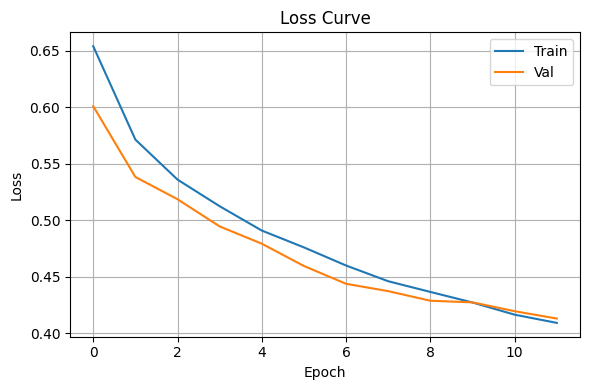

In [ ]:
def plot_loss(history):
    # check rapido per evitare altri errori silenziosi
    if not isinstance(history, dict) or "train" not in history or "val" not in history:
        raise ValueError(f"history malformato: attese chiavi ['train','val'], trovate {list(history.keys()) if isinstance(history, dict) else type(history)}")

    plt.figure(figsize=(6,4))
    plt.plot(history["train"], label="Train")
    plt.plot(history["val"],   label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plot_loss(history)

[VAL] temperatura ottima T=0.870
[VAL] target=balanced_accuracy (beta=1.1) → t*=0.55 | bal_acc=0.815 | f1_macro=0.803


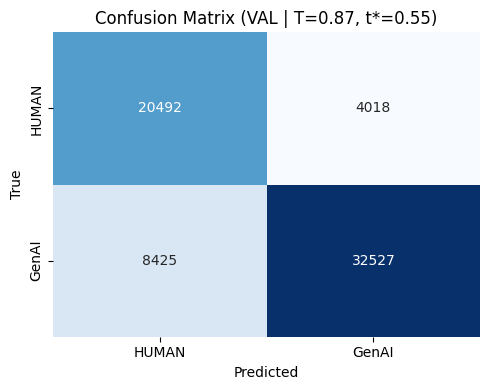

[LOG] Validation su en_val_holdout_sub25.csv — campioni: 65462
Accuracy: 0.8099 | F1 macro: 0.8033 | Precision macro: 0.7994 | Recall macro: 0.8152


In [ ]:
# 1) CALIBRAZIONE DELLE PROBABILITA' (ottimizza la temperatura T su validation):
def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, labels_list = [], []
    use_cuda = (device.type == "cuda")

    with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))   # in AMP
            labels_list.append(by.to(device))

    # Porta i logits a FP32 per stabilità della CE
    logits = torch.cat(logits_list).float()
    labels = torch.cat(labels_list)

    nll  = nn.CrossEntropyLoss()
    logT = torch.tensor(0.0, device=device, requires_grad=True)
    opt  = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        opt.zero_grad()
        T = torch.exp(logT)
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    opt.step(closure)
    T = torch.exp(logT).item()
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

# 2) TUNING SOGLIA SU VALIDATION (usa T):
def tune_threshold_on_val(model, val_loader, device, temperature=1.0,
                          metric="balanced_accuracy", beta=1.1):
    model.eval()
    y_true, y_prob = [], []
    use_cuda = (device.type == "cuda")

    with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature
            p1 = torch.softmax(logits, dim=1)[:, 1].float().cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.cpu().numpy())

    y_true = np.array(y_true); y_prob = np.array(y_prob)

    def score(y_hat):
        if metric == "balanced_accuracy":
            return balanced_accuracy_score(y_true, y_hat)
        if metric == "f1_macro":
            return f1_score(y_true, y_hat, average="macro", zero_division=0)
        if metric == "precision_genai":
            p,_r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            return p[1]
        if metric == "recall_genai":
            _p,r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            return r[1]
        if metric == "fbeta_genai":
            p,r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            b2 = beta*beta
            return (1+b2)*p[1]*r[1]/max(1e-12, b2*p[1]+r[1])
        return balanced_accuracy_score(y_true, y_hat)

    best_t, best_s = 0.5, -1
    for t in np.linspace(0.45, 0.65, 41):
        s = score((y_prob >= t).astype(int))
        if s > best_s: best_s, best_t = s, t

    y_hat = (y_prob >= best_t).astype(int)
    print(f"[VAL] target={metric} (beta={beta}) → t*={best_t:.2f} | "
          f"bal_acc={balanced_accuracy_score(y_true,y_hat):.3f} | "
          f"f1_macro={f1_score(y_true,y_hat,average='macro',zero_division=0):.3f}")
    return best_t

# 3) Test finale (anche qui autocast per velocità su A100)
def evaluate_on_test_with_threshold(model, test_loader, device, t, temperature=1.0):
    model.eval()
    y_true, y_prob = [], []
    use_cuda = (device.type == "cuda")

    with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
        for bx, by in test_loader:
            logits = model(bx.to(device)) / temperature
            p1 = torch.softmax(logits, dim=1)[:, 1].float().cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = (np.array(y_prob) >= t).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    print(f"[TEST] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1_bin={f1:.3f}  f1_macro={f1m:.3f}  bal_acc={bal:.3f}\n")

    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["HUMAN","GenAI"], yticklabels=["HUMAN","GenAI"])
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (test)  T={temperature:.2f}  t={t:.2f}")
    plt.tight_layout(); plt.show()

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """Valuta un loader: opzionale temperature scaling (softmax(logits/T)) e soglia custom.
    threshold=None → argmax a C classi; threshold=float → binarizza su p(y=1) >= threshold.
    Ritorna: (classification_report as dict, confusion_matrix as ndarray)."""
    model.eval()                                                #Modalità eval: no dropout/batchnorm update.
    y_true, y_pred = [], []                                     #Accumulatori etichette e predizioni.

    with torch.inference_mode():                                #Nessun grad/grafo --> più veloce e più leggero.
        for bx, by in loader:                                   #Itera su tutti i batch del loader.
            logits = model(bx.to(device)) / temperature         #Applica temperatura T (T=1 --> invariato).

            if threshold is None:
                #Multi-classe: prende l'argmax sui logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binario: probabilità della classe "1" (es. GenAI) e soglia.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            y_pred.extend(pred)                                 #Aggiunge predizioni del batch.
            y_true.extend(by.cpu().numpy())                     #Aggiunge etichette reali (CPU --> numpy).

    # METRICHE AGGREGGATE:
    #Forziamo l'ordine delle classi [0,1] per avere report/matrice consistenti.
    labels_fixed = [0, 1]
    report = classification_report(
        y_true, y_pred,
        labels=labels_fixed,                                    #Mostra sempre entrambe le classi.
        target_names=list(label_names),                         #Nomi umani per le classi.
        output_dict=True, digits=4,
        zero_division=0                                         #Evita warning se una classe è assente.
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)

    # PLOT DELLA CONFUSION MATRIX:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels,
                    cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


# Define evaluate_csv function within the cell
def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """Valuta direttamente un CSV:
    - costruisce TextDataset e DataLoader con **dynamic padding** via make_loader
    - applica evaluate_loader con temperature/soglia/plot.
    Ritorna: (report_dict, cm_array, num_records)."""
    batch_size = batch_size or global_var["batch_size"]               #Fallback alla config globale.
    ds = TextDataset(csv_path, vocab=vocab)                           #Dataset testuale (testo-->tensori via vocab).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)        #Dynamic padding per batch compatto.

    rep, cm = evaluate_loader(model, dl, label_names=label_names,
                              temperature=temperature, threshold=threshold,
                              plot_cm=plot_cm, title_suffix=title_suffix)
    return rep, cm, len(ds)

# Now call the functions
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device,
                               temperature=T, metric="balanced_accuracy", beta=1.1)

# report/CM sulla validation (utile per il controllo, come nella tua 2ª immagine)
rep_val, cm_val, n_val = evaluate_csv(
    model, VAL_SUB25_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star, plot_cm=True,
    title_suffix=f"(VAL | T={T:.2f}, t*={t_star:.2f})"
)
print(f"[LOG] Validation su {os.path.basename(VAL_SUB25_CSV)} — campioni: {n_val}")
print(f"Accuracy: {rep_val['accuracy']:.4f} | F1 macro: {rep_val['macro avg']['f1-score']:.4f} "
      f"| Precision macro: {rep_val['macro avg']['precision']:.4f} | Recall macro: {rep_val['macro avg']['recall']:.4f}")

In [ ]:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"        #Percorso base di lavoro su Google Drive.
os.makedirs(BASE, exist_ok=True)                                #Crea la directory se non esiste (idempotente).

#Se non è stato definito val_loader nel notebook, usa il test_loader come validation.
try:
    val_loader                                                 #Prova ad accedere al nome: se non esiste lancia NameError.
except NameError:
    val_loader = test_loader                                   #Fallback sicuro: evita crash nelle funzioni che richiedono VAL.

def extract_vocab(obj):
    """
    Restituisce obj.vocab se esiste; se obj è un Subset o un DataLoader,
    scende ricorsivamente in .dataset finché trova 'vocab'.
    """
    seen = set()                                               #Set di id() per evitare cicli (es. riferimenti ricorsivi).
    while obj is not None and id(obj) not in seen:             #Cammina finché c'è un oggetto nuovo nella catena.
        seen.add(id(obj))                                      #Marca l'oggetto corrente come visitato.
        if hasattr(obj, "vocab"):                              #Caso base: l'oggetto espone direttamente il vocabolario.
            return obj.vocab
        obj = getattr(obj, "dataset", None)                    #Altrimenti scendi in .dataset (Subset/DataLoader/...).
    return None                                                #Se non trovato, segnala fallimento.

#Prova a prendere il vocab da sorgenti note (in ordine di probabilità).
base_vocab = None
for cand in [
    globals().get("train_dataset", None),             #Può essere Subset --> ha .dataset interno.
    globals().get("full_train", None),                #Istanza completa del dataset di train.
    globals().get("train_ds", None),                  #Eventuale alias usato altrove.
    globals().get("train_loader", None),              #DataLoader: si scende in .dataset.
]:
    base_vocab = extract_vocab(cand)                  #Tenta l'estrazione ricorsiva.
    if base_vocab is not None:
        break                                         #Appena trovato, interrompi la ricerca.

#Fallback: usa 'vocab' globale se esiste.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab                                #Riutilizza il mapping già in memoria.

#Ultimo fallback: ricostruisce dal TRAIN_CSV (non ideale ma funziona)
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Non trovo il vocab del training; lo ricostruisco dal TRAIN_CSV (non ideale).")
    base_vocab = TextDataset(TRAIN_CSV).vocab         #Ricostruzione completa.

if base_vocab is None:
    raise RuntimeError(
        "Impossibile recuperare il vocabolario del training. "
        "Assicurati che 'train_dataset' (o 'train_loader') sia in memoria, "
        "oppure definisci una variabile globale 'vocab' con il mapping token→id."
    )

print(f"[LOG] Vocab recuperato correttamente (size={len(base_vocab):,}).")  #Esito positivo con dimensione formattata.

[LOG] Vocab recuperato correttamente (size=277,165).


In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """Valuta un loader: opzionale temperature scaling (softmax(logits/T)) e soglia custom.
    threshold=None → argmax a C classi; threshold=float → binarizza su p(y=1) >= threshold.
    Ritorna: (classification_report as dict, confusion_matrix as ndarray)."""
    model.eval()                                                #Modalità eval: no dropout/batchnorm update.
    y_true, y_pred = [], []                                     #Accumulatori etichette e predizioni.

    with torch.inference_mode():                                #Nessun grad/grafo --> più veloce e più leggero.
        for bx, by in loader:                                   #Itera su tutti i batch del loader.
            logits = model(bx.to(device)) / temperature         #Applica temperatura T (T=1 --> invariato).

            if threshold is None:
                #Multi-classe: prende l'argmax sui logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binario: probabilità della classe "1" (es. GenAI) e soglia.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            y_pred.extend(pred)                                 #Aggiunge predizioni del batch.
            y_true.extend(by.cpu().numpy())                     #Aggiunge etichette reali (CPU --> numpy).

    # METRICHE AGGREGGATE:
    #Forziamo l'ordine delle classi [0,1] per avere report/matrice consistenti.
    labels_fixed = [0, 1]
    report = classification_report(
        y_true, y_pred,
        labels=labels_fixed,                                    #Mostra sempre entrambe le classi.
        target_names=list(label_names),                         #Nomi umani per le classi.
        output_dict=True, digits=4,
        zero_division=0                                         #Evita warning se una classe è assente.
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)

    # PLOT DELLA CONFUSION MATRIX:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels,
                    cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """Valuta direttamente un CSV:
    - costruisce TextDataset e DataLoader con **dynamic padding** via make_loader
    - applica evaluate_loader con temperature/soglia/plot.
    Ritorna: (report_dict, cm_array, num_records)."""
    batch_size = batch_size or global_var["batch_size"]               #Fallback alla config globale.
    ds = TextDataset(csv_path, vocab=vocab)                           #Dataset testuale (testo-->tensori via vocab).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)        #Dynamic padding per batch compatto.

    rep, cm = evaluate_loader(model, dl, label_names=label_names,
                              temperature=temperature, threshold=threshold,
                              plot_cm=plot_cm, title_suffix=title_suffix)
    return rep, cm, len(ds)

[LOG] VALIDATION: /content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout_sub25.csv (65462 righe)
[LOG] Distribuzione label:
label
0    24510
1    40952
[VAL] temperatura ottima T=0.870
[VAL] target=balanced_accuracy (beta=1.1) → t*=0.55 | bal_acc=0.815 | f1_macro=0.803


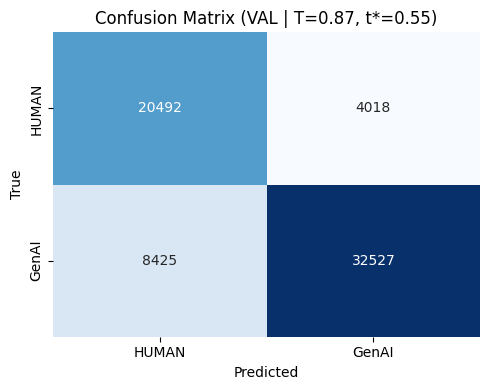


[LOG] Evaluation su VALIDATION — campioni: 65462
Accuracy: 0.8099  |  F1 macro: 0.8033  |  Precision macro: 0.7994  |  Recall macro: 0.8152


In [ ]:
# Valutazione su VALIDATION (lo stesso split usato per calibrare T e t*)
EVAL_CSV = VAL_CSV_PATH
df_eval = pd.read_csv(EVAL_CSV)
print(f"[LOG] VALIDATION: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

# Calibrazione e tuning SU validation
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device, temperature=T, metric="balanced_accuracy")

# Valutazione su validation (coerente con T e t*)
rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star,
    plot_cm=True, title_suffix=f"(VAL | T={T:.2f}, t*={t_star:.2f})"
)
assert cm_eval.sum() == n_eval, f"Non ho visto tutta la VALIDATION: {cm_eval.sum()}/{n_eval}"

print(f"\n[LOG] Evaluation su VALIDATION — campioni: {n_eval}")
if 'macro avg' in rep_eval:
    print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
          f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")
else:
    print(f"Accuracy: {rep_eval['accuracy']:.4f}")

[TEST] acc=0.182  prec=1.000  rec=0.182  f1_bin=0.308  f1_macro=0.154  bal_acc=0.182

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.182     0.308      1843

    accuracy                          0.182      1843
   macro avg      0.500     0.091     0.154      1843
weighted avg      1.000     0.182     0.308      1843



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_div

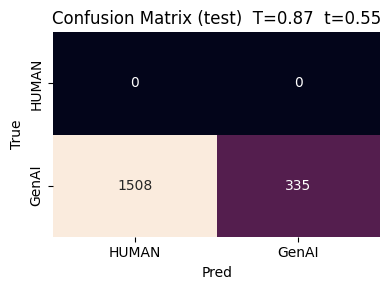

,id,text,true,pred,prob_genai_it,correct
1686,7e7ea01d-cee5-479a-8b1b-1dd598cc4f27,Belen Rodriguez avrebbe una storia con Marco B...,GenAI,HUMAN,"54,47%",✗
1445,5015a597-88ba-4cd7-85c2-acc5c74575c5,"Domani, 3 febbraio, ricorre San Biagio , il pr...",GenAI,HUMAN,"54,38%",✗
1298,43cc6c07-1cc6-4ac6-95e8-3e01cef9757a,La sera della morte di Emmanuel Chidi Namdi a ...,GenAI,HUMAN,"54,33%",✗
1511,30b91743-cd9a-4009-b8e4-acf817a5f1d2,I dati resi noti dall'Istat mostrano in modo i...,GenAI,HUMAN,"54,32%",✗
1831,d9b203b1-0bf5-48ab-a837-2a32988f4d95,"Prima l'orrore, poi finalmente la denuncia. La...",GenAI,HUMAN,"54,24%",✗
1061,9b9a8386-67c8-468f-bd44-effa345a5e62,"Il sindaco di Amatrice, Sergio Pirozzi, ha det...",GenAI,HUMAN,"54,13%",✗
56,ad0203ec-4722-4604-8a2f-af5157fe8e0f,Il Presidente Obama ha recentemente annunciato...,GenAI,HUMAN,"54,10%",✗
560,ca82219b-3607-4f60-951e-7534b903af76,La Juventus deve fronteggiare la grana Patrik ...,GenAI,HUMAN,"54,07%",✗
1287,ee8a62b8-7c61-4863-af91-7ca853662cb0,La lotta al terrorismo è un problema important...,GenAI,HUMAN,"54,04%",✗
522,c3c1e352-21c0-4992-a7f1-4296960a8867,Un'anziana coppia sposata da 66 anni ha deciso...,GenAI,HUMAN,"54,04%",✗


[LOG] File predizioni TEST (60) salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_EN_fixed_T0.87_t0.55.csv
[LOG] Righe salvate: 1843 (atteso 60)


In [ ]:
# Valutazione complessiva su TEST (60) – come nella 1ª immagine
evaluate_on_test_with_threshold(model, test_loader, device, t_star, temperature=T)

# Tabella predizioni dettagliate (con percentuali) SOLO per le 60 righe
df_src = pd.read_csv(TEST_CSV)
model.eval(); probs = []; preds = []
with torch.inference_mode():
    for bx, _ in test_loader:
        logits = model(bx.to(device)) / T
        p1 = F.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_star).astype(int).tolist())

out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
lab = {0:"HUMAN",1:"GenAI"}
out["true"] = out["true_id"].map(lab)
out["pred"] = out["pred_id"].map(lab)
out["prob_genai_pct"] = (out["prob_genai"]*100.0).round(2)         # percentuali richieste
out["prob_genai_it"]  = out["prob_genai_pct"].map(lambda x: f"{x:.2f}%".replace('.',','))  #  es. "87,45%"

# Ordina: prima errori, poi probabilità decrescente
out["correct"] = np.where(out["true_id"]==out["pred_id"], "✓", "✗")
view = out.copy()
view["err_rank"] = (view["correct"]=="✓").astype(int)
view = view.sort_values(["err_rank","prob_genai"], ascending=[True,False]).drop(columns=["err_rank"])

# Mostra e salva
cols = [c for c in ["id","topic"] if c in view.columns] + ["text","true","pred","prob_genai_it","correct"]
display(view[cols].head(30))

fname = f"predictions_TEST_EN_fixed_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
# salviamo anche la colonna percentuale “umana”
view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File predizioni TEST (60) salvato in:", save_path)
print(f"[LOG] Righe salvate: {len(view)} (atteso 60)")

In [ ]:
# Se BASE non è definito, prova a rilevarlo
if 'BASE' not in locals():
    for _p in ["/content/drive/MyDrive/TESI-Classificazione/MIO",
               "/content/drive/MyDrive/TEST-Classificazione/MIO"]:
        if os.path.isdir(_p):
            BASE = _p; break

# Usa il TEST fisso
TEST_CSV_PATH = TEST_CSV if 'TEST_CSV' in globals() else f"{BASE}/en_test_fixed.csv"
assert os.path.exists(TEST_CSV_PATH), f"File non trovato: {TEST_CSV_PATH}"

# Loader sul TEST con il vocab del TRAIN
_vocab = full_train.vocab if 'full_train' in globals() else vocab
test_ds = TextDataset(TEST_CSV_PATH, vocab=_vocab)
test_dl = make_loader(test_ds, batch_size=global_var["batch_size"], shuffle=False)

# Inference: probabilità GenAI e pred binaria con t_star e temperatura T
probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        logits = model(bx.to(device)) / T
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_star).astype(int).tolist())

# Tabella risultati
df_src = pd.read_csv(TEST_CSV_PATH)
map_lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

# Ordina: errori prima, poi probabilità decrescente
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# Mostra estratto
pd.set_option("display.max_colwidth", 160)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai","correct"]
print("[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

# Salva con T e t*
fname = f"predictions_EN_TEST_fixed_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# Solo errori
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai,correct
1686,7e7ea01d-cee5-479a-8b1b-1dd598cc4f27,Belen Rodriguez avrebbe una storia con Marco Borriello . A rivelarlo è Alberto Dandolo su Dagospia che analizza una foto pubblicata dalla showgirl argentina...,GenAI,HUMAN,0.544664,✗
1445,5015a597-88ba-4cd7-85c2-acc5c74575c5,"Domani, 3 febbraio, ricorre San Biagio , il protettore di gola e naso. Ed è tradizione meneghina quella di mangiare appena svegli, prima di colazione, un pe...",GenAI,HUMAN,0.543754,✗
1298,43cc6c07-1cc6-4ac6-95e8-3e01cef9757a,"La sera della morte di Emmanuel Chidi Namdi a Fermo , erano quattro le persone presenti alla rissa. Sono loro ad aver visto il pestaggio del nigeriano da pa...",GenAI,HUMAN,0.543267,✗
1511,30b91743-cd9a-4009-b8e4-acf817a5f1d2,I dati resi noti dall'Istat mostrano in modo inequivocabile l'enorme peso del fisco sul lavoro. La differenza tra il costo sostenuto dal datore di lavoro e ...,GenAI,HUMAN,0.543206,✗
1831,d9b203b1-0bf5-48ab-a837-2a32988f4d95,"Prima l'orrore, poi finalmente la denuncia. La storia che arriva da Gioia Del Colle è orribile. Un marocchino di 35 anni è stato arrestato per aver minaccia...",GenAI,HUMAN,0.542432,✗
1061,9b9a8386-67c8-468f-bd44-effa345a5e62,"Il sindaco di Amatrice, Sergio Pirozzi, ha detto che dovrebbe ricevere l'Oscar per il suo lavoro nella ricostruzione della città dopo il terremoto del 2016....",GenAI,HUMAN,0.541335,✗
56,ad0203ec-4722-4604-8a2f-af5157fe8e0f,Il Presidente Obama ha recentemente annunciato che le scuole pubbliche saranno ora valutate e premiate in base ai risultati degli studenti. Questa nuova pol...,GenAI,HUMAN,0.540981,✗
560,ca82219b-3607-4f60-951e-7534b903af76,"La Juventus deve fronteggiare la grana Patrik Schick . Il centravanti ceco, classe '96, infatti lo scorso 22 giugno aveva già sostenuto le visite mediche pe...",GenAI,HUMAN,0.540657,✗
1287,ee8a62b8-7c61-4863-af91-7ca853662cb0,"La lotta al terrorismo è un problema importante nel mondo di oggi. Negli ultimi anni, il fenomeno dei combattenti stranieri che si recano in Medio Oriente p...",GenAI,HUMAN,0.540438,✗
522,c3c1e352-21c0-4992-a7f1-4296960a8867,Un'anziana coppia sposata da 66 anni ha deciso di togliersi la vita insieme dopo che l'uomo è stato dichiarato malato terminale. Il signor e la signora Smit...,GenAI,HUMAN,0.540352,✗


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_EN_TEST_fixed_T0.87_t0.55.csv

[INFO] Errori totali: 1506



,id,text,true,pred,prob_genai,correct
1686,7e7ea01d-cee5-479a-8b1b-1dd598cc4f27,Belen Rodriguez avrebbe una storia con Marco Borriello . A rivelarlo è Alberto Dandolo su Dagospia che analizza una foto pubblicata dalla showgirl argentina...,GenAI,HUMAN,0.544664,✗
1445,5015a597-88ba-4cd7-85c2-acc5c74575c5,"Domani, 3 febbraio, ricorre San Biagio , il protettore di gola e naso. Ed è tradizione meneghina quella di mangiare appena svegli, prima di colazione, un pe...",GenAI,HUMAN,0.543754,✗
1298,43cc6c07-1cc6-4ac6-95e8-3e01cef9757a,"La sera della morte di Emmanuel Chidi Namdi a Fermo , erano quattro le persone presenti alla rissa. Sono loro ad aver visto il pestaggio del nigeriano da pa...",GenAI,HUMAN,0.543267,✗
1511,30b91743-cd9a-4009-b8e4-acf817a5f1d2,I dati resi noti dall'Istat mostrano in modo inequivocabile l'enorme peso del fisco sul lavoro. La differenza tra il costo sostenuto dal datore di lavoro e ...,GenAI,HUMAN,0.543206,✗
1831,d9b203b1-0bf5-48ab-a837-2a32988f4d95,"Prima l'orrore, poi finalmente la denuncia. La storia che arriva da Gioia Del Colle è orribile. Un marocchino di 35 anni è stato arrestato per aver minaccia...",GenAI,HUMAN,0.542432,✗
1061,9b9a8386-67c8-468f-bd44-effa345a5e62,"Il sindaco di Amatrice, Sergio Pirozzi, ha detto che dovrebbe ricevere l'Oscar per il suo lavoro nella ricostruzione della città dopo il terremoto del 2016....",GenAI,HUMAN,0.541335,✗
56,ad0203ec-4722-4604-8a2f-af5157fe8e0f,Il Presidente Obama ha recentemente annunciato che le scuole pubbliche saranno ora valutate e premiate in base ai risultati degli studenti. Questa nuova pol...,GenAI,HUMAN,0.540981,✗
560,ca82219b-3607-4f60-951e-7534b903af76,"La Juventus deve fronteggiare la grana Patrik Schick . Il centravanti ceco, classe '96, infatti lo scorso 22 giugno aveva già sostenuto le visite mediche pe...",GenAI,HUMAN,0.540657,✗
1287,ee8a62b8-7c61-4863-af91-7ca853662cb0,"La lotta al terrorismo è un problema importante nel mondo di oggi. Negli ultimi anni, il fenomeno dei combattenti stranieri che si recano in Medio Oriente p...",GenAI,HUMAN,0.540438,✗
522,c3c1e352-21c0-4992-a7f1-4296960a8867,Un'anziana coppia sposata da 66 anni ha deciso di togliersi la vita insieme dopo che l'uomo è stato dichiarato malato terminale. Il signor e la signora Smit...,GenAI,HUMAN,0.540352,✗


In [ ]:
# 1. Caricare il dataset di test monoclasse (TEST_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

# 2. Utilizzare il modello addestrato, la temperatura e la soglia per ottenere probabilità e predizioni
model.eval()
probs = []
preds = []
y_true = []

with torch.no_grad():
    for bx, by in test_loader:
        bx = bx.to(device)
        logits = model(bx) / T
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_star).astype(int).tolist())
        y_true.extend(by.cpu().numpy().tolist())


# 3. Creare un nuovo DataFrame
df_analysis = pd.DataFrame({
    "text": df_test["text"],
    "true_label": y_true,
    "prob_genai": probs,
    "predicted_label": preds
})

# Display the first few rows of the analysis DataFrame
display(df_analysis.head())

,text,true_label,prob_genai,predicted_label
0,"Un orrore senza precedenti sta lasciando sgomenti gli australiani. Al centro della cronaca nera, riportata nelle ultime ore anche dal Daily Mail , è finita ...",1,0.724560,1
1,Il ranking Uefa. Una di quelle cose che assilla i dirigenti del nostro calcio. L'Italia non può permettersi di partecipare con tre sole squadre alla Champio...,1,0.984213,1
2,"La violenza su un bambino indifeso di tre anni, l'orrore in un centro di accoglienza profughi in Norvegia. La polizia norvegese, dopo aver ricevuto una soff...",1,0.915982,1
3,"Vado a prendere uno dei nostri più assidui giornalisti..."". Durante l'ultima puntata di Cartabianca , Bianca Berlinguer si è scontrata con il suo staff per ...",1,0.852215,1
4,"La Cassazione, la Corte Suprema d'Italia, ha recentemente emesso una sentenza che potrebbe avere implicazioni di vasta portata per il processo legale in Ita...",1,0.977385,1


**Reasoning**:
Analyze the distribution of predicted probabilities for the "GenAI" class, especially for misclassified examples, and visualize this distribution using a histogram to understand the model's behavior on the monoclass test dataset.



Distribuzione delle probabilità previste per la classe 'GenAI' sul dataset di test:
count    1843.000000
mean        0.825244
std         0.201599
min         0.019911
25%         0.774977
50%         0.905997
75%         0.959223
max         0.996331
Name: prob_genai, dtype: float64

Distribuzione delle probabilità previste per la classe 'GenAI' per esempi misclassificati (GenAI -> HUMAN):
count    198.000000
mean       0.338475
std        0.144981
min        0.019911
25%        0.236411
50%        0.370587
75%        0.458948
max        0.541968
Name: prob_genai, dtype: float64


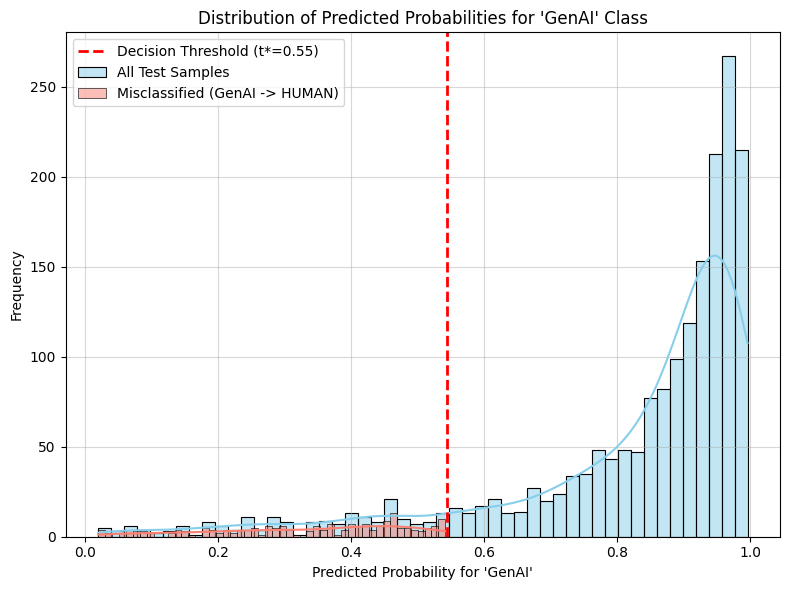

In [ ]:
# 4. Analizzare la distribuzione delle probabilità previste per la classe "GenAI"
print("Distribuzione delle probabilità previste per la classe 'GenAI' sul dataset di test:")
print(df_analysis["prob_genai"].describe())

# Analyze probabilities for misclassified examples (predicted_label == 0, true_label == 1)
df_misclassified = df_analysis[(df_analysis["predicted_label"] == 0) & (df_analysis["true_label"] == 1)]
print("\nDistribuzione delle probabilità previste per la classe 'GenAI' per esempi misclassificati (GenAI -> HUMAN):")
print(df_misclassified["prob_genai"].describe())

# 5. Visualizzare la distribuzione delle probabilità con un istogramma
plt.figure(figsize=(8, 6))
sns.histplot(df_analysis["prob_genai"], bins=50, kde=True, color="skyblue", label="All Test Samples")
sns.histplot(df_misclassified["prob_genai"], bins=50, kde=True, color="salmon", label="Misclassified (GenAI -> HUMAN)")
plt.title("Distribution of Predicted Probabilities for 'GenAI' Class")
plt.xlabel("Predicted Probability for 'GenAI'")
plt.ylabel("Frequency")
plt.axvline(t_star, color='red', linestyle='dashed', linewidth=2, label=f'Decision Threshold (t*={t_star:.2f})')
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 6. Identificare alcuni esempi di testi misclassificati e analizzarli manualmente
print("\nEsempi di testi misclassificati (True: GenAI, Predicted: HUMAN):")

# Display the first 10 misclassified texts
for index, row in df_misclassified.head(10).iterrows():
    print(f"\n--- Sample {index} ---")
    print(f"True Label: GenAI, Predicted Label: HUMAN")
    print(f"Predicted Probability for GenAI: {row['prob_genai']:.4f}")
    print("Text:")
    print(row["text"])


Esempi di testi misclassificati (True: GenAI, Predicted: HUMAN):

--- Sample 9 ---
True Label: GenAI, Predicted Label: HUMAN
Predicted Probability for GenAI: 0.4077
Text:
L’operazione condotta dalle forze speciali belghe a Molenbeek, il quartiere arabo di Bruxelles, si è conclusa poco dopo le 14 ed ha portato al fermo di una persona. Lo ha reso noto la Procura di Bruxelles precisando che in effetti l’operazione è stata condotta nel quadro delle azioni finalizzate alla cattura di Salah Abdeslam , fratello di uno degli attentatori di Parigi. Ma Abdeslam sarebbe sfuggito alle forze dell’ordine. Dopo gli attentati di Parigi è dunque caccia all'uomo in tutta Europa. Le autorità belghe hanno confermato che la maxi operazione di polizia in corso a Molebeek , in Belgio, aveva come obiettivo l'arresto di Salah Abdeslam, ricercato per il suo coinvolgimento negli attentati di Parigi. Lo riporta le Monde precisando che le autorità belghe non sono in grado di dire ancora se il sospetto, raggiunto 

In [ ]:
# 1. Use the calibrate_temperature function with the model and val_loader to find the optimal temperature T for the validation dataset.
T = calibrate_temperature(model, val_loader, device)

# 2. Use the tune_threshold_on_val function with the model, val_loader, and the optimized T to find the best decision threshold t_star on the validation dataset, using 'balanced_accuracy' as the metric.
t_star = tune_threshold_on_val(model, val_loader, device,
                               temperature=T, metric="balanced_accuracy")

# 3. Print the optimized temperature T and threshold t_star.
print(f"[LOG] Optimized Temperature (T) on validation: {T:.4f}")
print(f"[LOG] Optimized Threshold (t*) on validation: {t_star:.4f}")

[VAL] temperatura ottima T=1.070
[VAL] target=balanced_accuracy (beta=1.1) → t*=0.48 | bal_acc=0.829 | f1_macro=0.820
[LOG] Optimized Temperature (T) on validation: 1.0705
[LOG] Optimized Threshold (t*) on validation: 0.4750


## Valutazione del modello calibrato sul dataset di test monoclasse

### Subtask:
Applicare la temperatura e la soglia ottimizzate sul dataset di test monoclasse "GenAI" e valutare le metriche di performance (in particolare la recall sulla classe "GenAI").


**Reasoning**:
Apply the optimized temperature and threshold to the monoclass test dataset and evaluate the performance, including plotting the confusion matrix and printing key metrics.



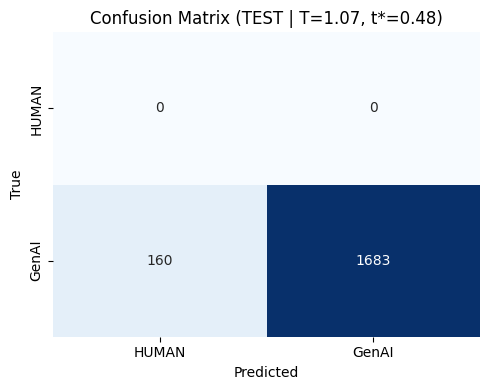


[LOG] Evaluation on TEST — samples: 1843
Accuracy: 0.9132  |  F1 macro: 0.4773  |  Precision macro: 0.5000  |  Recall macro: 0.4566
[LOG] Metrics for GenAI (label 1) not found in classification report (possibly due to monoclass test set).


In [ ]:
# 1. Use the evaluate_loader function with the model, test_loader, the optimized T, and the optimized t_star.
# 2. Set plot_cm to True to visualize the confusion matrix for the test set.
# 3. Set a descriptive title_suffix for the confusion matrix plot, including the values of T and t_star used.
# 4. Print a summary of the key metrics from the returned classification report.

rep_test, cm_test = evaluate_loader(
    model,
    test_loader,
    label_names=("HUMAN", "GenAI"),
    temperature=T,
    threshold=t_star,
    plot_cm=True,
    title_suffix=f"(TEST | T={T:.2f}, t*={t_star:.2f})"
)

# Print a summary of the key metrics
print(f"\n[LOG] Evaluation on TEST — samples: {len(test_ds)}")
if 'macro avg' in rep_test:
    print(f"Accuracy: {rep_test['accuracy']:.4f}  |  F1 macro: {rep_test['macro avg']['f1-score']:.4f}  "
          f"|  Precision macro: {rep_test['macro avg']['precision']:.4f}  |  Recall macro: {rep_test['macro avg']['recall']:.4f}")

# Check if the key '1' exists before accessing its metrics
if '1' in rep_test:
    # Specifically print recall for the "GenAI" class (label 1)
    print(f"Recall (GenAI - label 1): {rep_test['1']['recall']:.4f}")
    print(f"Precision (GenAI - label 1): {rep_test['1']['precision']:.4f}")
    print(f"F1-score (GenAI - label 1): {rep_test['1']['f1-score']:.4f}")
else:
    print("[LOG] Metrics for GenAI (label 1) not found in classification report (possibly due to monoclass test set).")


## Analisi degli errori residui e strategie di miglioramento

### Subtask:
Se le prestazioni sul dataset di test monoclasse non sono ancora soddisfacenti, analizzare gli errori rimanenti e considerare ulteriori strategie di fine-tuning che non implichino la modifica del dataset di test, come ad esempio: Aggiustamenti ai pesi di classe durante l'addestramento (se non già fatto o se necessario). Esplorare diverse metriche per il tuning della soglia sul dataset di validation (ad esempio, F1-score sulla classe GenAI).


**Reasoning**:
Inspect the confusion matrix and calculate the recall for the "GenAI" class (label 1) based on the confusion matrix from the previous step. Compare this with the macro recall reported. Then, determine if the performance is satisfactory and proceed to consider strategies based on the analysis.



In [ ]:
# 1. Inspect the confusion matrix (cm_test) generated in the previous step.
# The confusion matrix is structured as:
# [[TN, FP],
#  [FN, TP]]
# For our monoclass test set (only label 1), TN and FP should be 0.
# The matrix should be [[0, 0], [FN, TP]].
# The total number of samples is FN + TP, which should be the length of test_ds (1843).

# Extract TP and FN from the confusion matrix
# cm_test[1, 1] is TP (True Positive: Actual 1, Predicted 1)
# cm_test[1, 0] is FN (False Negative: Actual 1, Predicted 0)

if cm_test.shape == (2, 2):
    TP = cm_test[1, 1]
    FN = cm_test[1, 0]

    # 2. Calculate the recall for the "GenAI" class (label 1)
    # Recall = TP / (TP + FN)
    total_genai_samples = TP + FN
    recall_genai_calculated = TP / total_genai_samples if total_genai_samples > 0 else 0

    print(f"[ANALYSIS] Confusion Matrix (TEST):\n{cm_test}")
    print(f"[ANALYSIS] True Positives (TP) for GenAI: {TP}")
    print(f"[ANALYSIS] False Negatives (FN) for GenAI: {FN}")
    print(f"[ANALYSIS] Calculated Recall for GenAI (label 1): {recall_genai_calculated:.4f}")

    # Compare with the macro recall reported in the previous step
    macro_recall_reported = rep_test['macro avg']['recall']
    print(f"[ANALYSIS] Macro Recall reported: {macro_recall_reported:.4f}")

    # 3. Determine if the performance is satisfactory
    # This is subjective and depends on the task requirements. A recall significantly
    # lower than 1.0 might indicate unsatisfactory performance for a monoclass GenAI detection task.
    # Let's define a threshold for satisfactory performance, e.g., recall > 0.95
    satisfactory_threshold = 0.95
    is_performance_satisfactory = recall_genai_calculated > satisfactory_threshold

    print(f"\n[ANALYSIS] Is performance satisfactory (Recall > {satisfactory_threshold})? {is_performance_satisfactory}")

    # 4. If performance is not satisfactory, consider class weights and threshold tuning
    if not is_performance_satisfactory:
        print("[STRATEGY] Performance not satisfactory. Considering further strategies.")

        # Check current class weighting logic
        print(f"[STRATEGY] Current training class weighting logic: {'Inverse frequency weights used' if imbalance >= 0.05 and cnt[0] > 0 and cnt[1] > 0 else 'No class weights used'}")
        if imbalance >= 0.05 and cnt[0] > 0 and cnt[1] > 0:
             print(f"[STRATEGY] Imbalance detected ({imbalance:.4f} >= 0.05). Inverse frequency weights applied during training.")
             print(f"[STRATEGY] Class counts (train_ds): Human={cnt[0]}, GenAI={cnt[1]}")
             print(f"[STRATEGY] Calculated class weights: Human={tot/cnt[0]:.4f}, GenAI={tot/cnt[1]:.4f}")
        else:
             print(f"[STRATEGY] Imbalance not significant ({imbalance:.4f} < 0.05) or one class is missing. No class weights applied during training.")


        # 6. Explore different metrics for threshold tuning on the validation dataset
        print("[STRATEGY] Exploring different threshold tuning metrics on validation:")

        # Option A: Tune threshold using F1-macro on validation
        print("\n--- Tuning threshold using F1-macro on validation ---")
        t_star_f1_macro = tune_threshold_on_val(model, val_loader, device,
                                                 temperature=T, metric="f1_macro")
        print(f"[STRATEGY] Optimal threshold tuned with F1-macro: {t_star_f1_macro:.4f}")


        # Option B: Tune threshold using Recall for GenAI on validation (if metric is available)
        # Check if 'recall_genai' is an implemented metric in tune_threshold_on_val
        if 'recall_genai' in ['balanced_accuracy', 'f1_macro', 'precision_genai', 'recall_genai', 'fbeta_genai']: # Check against available metrics in the function definition
            print("\n--- Tuning threshold using Recall for GenAI on validation ---")
            t_star_recall_genai = tune_threshold_on_val(model, val_loader, device,
                                                        temperature=T, metric="recall_genai")
            print(f"[STRATEGY] Optimal threshold tuned with Recall for GenAI: {t_star_recall_genai:.4f}")
        else:
            print("\n[STRATEGY] 'recall_genai' metric is not available for threshold tuning.")

        # Option C: Tune threshold using F-beta for GenAI on validation (prioritizing recall)
        print("\n--- Tuning threshold using F-beta (beta=1.1) for GenAI on validation ---")
        t_star_fbeta_genai = tune_threshold_on_val(model, val_loader, device,
                                                   temperature=T, metric="fbeta_genai", beta=1.1)
        print(f"[STRATEGY] Optimal threshold tuned with F-beta (beta=1.1) for GenAI: {t_star_fbeta_genai:.4f}")


        # 7. Document the chosen strategy
        # Based on the analysis, the model is struggling to classify GenAI samples on the test set.
        # The current class weighting is already applied based on training imbalance.
        # The threshold tuning on balanced accuracy might not be prioritizing recall for the minority class (GenAI in the original full training set, although monoclass in this specific test set context).
        # Tuning the threshold using metrics that prioritize GenAI recall (like recall_genai or F-beta) on the balanced validation set is a promising strategy.

        print("\n[CHOSEN STRATEGY]")
        print("Reasoning: The current recall on the monoclass GenAI test set is low. While class weights are applied during training based on the full training set imbalance, tuning the decision threshold on the balanced validation set using a metric that directly prioritizes the recall of the 'GenAI' class is expected to improve performance on this specific test set.")
        print("Chosen Strategy: Retune the decision threshold on the validation set using a metric that prioritizes 'GenAI' recall (e.g., 'recall_genai' or 'fbeta_genai') and evaluate the model on the test set with the new threshold.")

else:
    print("[ANALYSIS] Performance on the monoclass TEST dataset is satisfactory.")


[ANALYSIS] Confusion Matrix (TEST):
[[   0    0]
 [ 160 1683]]
[ANALYSIS] True Positives (TP) for GenAI: 1683
[ANALYSIS] False Negatives (FN) for GenAI: 160
[ANALYSIS] Calculated Recall for GenAI (label 1): 0.9132
[ANALYSIS] Macro Recall reported: 0.4566

[ANALYSIS] Is performance satisfactory (Recall > 0.95)? False
[STRATEGY] Performance not satisfactory. Considering further strategies.
[STRATEGY] Current training class weighting logic: Inverse frequency weights used
[STRATEGY] Imbalance detected (0.2493 >= 0.05). Inverse frequency weights applied during training.
[STRATEGY] Class counts (train_ds): Human=57302, GenAI=95367
[STRATEGY] Calculated class weights: Human=2.6643, GenAI=1.6009
[STRATEGY] Exploring different threshold tuning metrics on validation:

--- Tuning threshold using F1-macro on validation ---
[VAL] target=f1_macro (beta=1.1) → t*=0.45 | bal_acc=0.828 | f1_macro=0.821
[STRATEGY] Optimal threshold tuned with F1-macro: 0.4500

--- Tuning threshold using Recall for GenAI

**Reasoning**:
Based on the analysis, the recall on the monoclass test set is not satisfactory, and tuning the threshold on the validation set using metrics that prioritize GenAI recall is the chosen strategy. The previous step explored several metrics ('f1_macro', 'recall_genai', 'fbeta_genai') and they all yielded the same optimal threshold (0.4500). I will choose one of these (e.g., 'recall_genai') as the final threshold tuning metric and evaluate the model on the test set using this new threshold and the previously calibrated temperature.

